# Generate Embeddings for Markdown Chunks (v3)

This notebook generates embeddings for markdown chunks that were created using the header-based chunking approach. It loads chunks from the `data/chunks` directory, generates embeddings using Sentence Transformers, and saves the results in various formats.

This is an adaptation of the `generate_embeddings_v2.ipynb` notebook, modified to work with the new chunking format.

## Imports

In [15]:
import os
import json
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import logging
from tqdm.notebook import tqdm
from datetime import datetime
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Setup logging

In [16]:
# Set up logging
LOG_DIR = "../logs"
os.makedirs(LOG_DIR, exist_ok=True)

LOG_FILE = os.path.join(LOG_DIR, f"generate_embeddings_v3_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(LOG_FILE),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger("generate_embeddings_v3")

## Configuration

In [17]:
# Define constants
CHUNKS_DIR = "../data/chunks"
OUTPUT_DIR = "../data/embeddings"
MODEL_NAME = "all-MiniLM-L6-v2"  # Using the better quality model as requested
ENCODING_BATCH_SIZE = 32  # Batch size for encoding
USE_ALL_CHUNKS = True  # Set to True to use all_chunks_by_header.json, False to process individual files

# Create output directory if it doesn't exist
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join(OUTPUT_DIR, f"header_chunks_{MODEL_NAME.replace('-', '_')}_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

logger.info(f"Using model: {MODEL_NAME}")
logger.info(f"Input directory: {CHUNKS_DIR}")
logger.info(f"Output directory: {output_dir}")

2025-05-12 23:14:25,106 - generate_embeddings_v3 - INFO - Using model: all-MiniLM-L6-v2
2025-05-12 23:14:25,107 - generate_embeddings_v3 - INFO - Input directory: ../data/chunks
2025-05-12 23:14:25,107 - generate_embeddings_v3 - INFO - Output directory: ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425


## Load Chunks

Load the chunks from either the combined file or individual files.

In [18]:
def load_chunks(chunks_dir, use_all_chunks=True):
    """
    Load chunks from either the combined file or individual files.
    
    Args:
        chunks_dir (str): Directory containing the chunk files
        use_all_chunks (bool): If True, load from all_chunks_by_header.json
                             If False, load from individual chunk files
    
    Returns:
        list: List of chunk dictionaries
    """
    all_chunks = []
    
    if use_all_chunks:
        # Load from the combined file
        all_chunks_file = os.path.join(chunks_dir, "all_chunks_by_header.json")
        if os.path.exists(all_chunks_file):
            logger.info(f"Loading chunks from {all_chunks_file}")
            with open(all_chunks_file, 'r', encoding='utf-8') as f:
                all_chunks = json.load(f)
            logger.info(f"Loaded {len(all_chunks)} chunks from combined file")
        else:
            logger.error(f"Combined chunks file not found: {all_chunks_file}")
    else:
        # Load from individual files
        chunk_files = glob.glob(os.path.join(chunks_dir, "*_chunks.json"))
        logger.info(f"Found {len(chunk_files)} individual chunk files")
        
        for file_path in tqdm(chunk_files, desc="Loading chunk files"):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    chunks = json.load(f)
                    all_chunks.extend(chunks)
            except Exception as e:
                logger.error(f"Error loading {file_path}: {str(e)}")
        
        logger.info(f"Loaded {len(all_chunks)} chunks from individual files")
    
    # Add a unique ID to each chunk if not already present
    for i, chunk in enumerate(all_chunks):
        if "id" not in chunk and "chunk_id" not in chunk:
            chunk["id"] = f"chunk_{i}"
    
    return all_chunks

In [19]:
# Load the chunks
chunks_data = load_chunks(CHUNKS_DIR, USE_ALL_CHUNKS)

# Display some statistics
print(f"Total chunks loaded: {len(chunks_data)}")

# Display sample chunk
if chunks_data:
    print("\nSample chunk:")
    sample_chunk = chunks_data[0]
    for key, value in sample_chunk.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"{key}: {value[:100]}...")
        else:
            print(f"{key}: {value}")

2025-05-12 23:14:25,241 - generate_embeddings_v3 - INFO - Loading chunks from ../data/chunks\all_chunks_by_header.json
2025-05-12 23:14:25,247 - generate_embeddings_v3 - INFO - Loaded 203 chunks from combined file


Total chunks loaded: 203

Sample chunk:
page_content: ## Your Career Success

Take the next step to advance your career with UChicago’s MS in Applied Data...
metadata: {'title': 'In-Person Program – DSI', 'original_url': 'https://datascience.uchicago.edu/education/masters-programs/in-person-program', 'category': 'education', 'date': '2025-05-04', 'source_file': 'C:\\Users\\alen.pavlovic\\Documents\\GitLab\\gen-ai-midterm-project\\data\\markdown_clean_final\\education_masters-programs_in-person-program.md', 'filename': 'education_masters-programs_in-person-program.md', 'section_level': 'main', 'section': 'Your Career Success', 'subsection': None, 'header_level': 2, 'header_text': 'Your Career Success', 'chunk_id': 'education_masters-programs_in-person-program_0', 'document_title': 'In-Person Program – DSI'}
id: chunk_0


## Initialize Sentence Transformer Model

In [20]:
def init_sentence_transformer_model(model_name):
    """
    Initialize the Sentence Transformer model.
    
    Args:
        model_name (str): Name of the pre-trained model to use
    
    Returns:
        SentenceTransformer: Initialized model
    """
    try:
        logger.info(f"Initializing Sentence Transformer model: {model_name}")
        model = SentenceTransformer(model_name)
        logger.info(f"Model initialized successfully. Embedding dimension: {model.get_sentence_embedding_dimension()}")
        return model
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        return None

In [21]:
# Initialize the model
model = init_sentence_transformer_model(MODEL_NAME)

2025-05-12 23:14:25,299 - generate_embeddings_v3 - INFO - Initializing Sentence Transformer model: all-MiniLM-L6-v2
2025-05-12 23:14:25,302 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-05-12 23:14:25,302 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-12 23:14:28,410 - generate_embeddings_v3 - INFO - Model initialized successfully. Embedding dimension: 384


## Generate Embeddings

In [22]:
def generate_embeddings_for_chunks(chunks_data, model, batch_size=ENCODING_BATCH_SIZE):
    """
    Generate embeddings for the provided chunks using the specified model.
    
    Args:
        chunks_data (list): List of chunk dictionaries
        model (SentenceTransformer): Initialized model
        batch_size (int): Batch size for encoding
    
    Returns:
        tuple: (numpy.ndarray of embeddings, list of chunks with embeddings added)
    """
    if not chunks_data or model is None:
        logger.error("No chunks data or model not initialized")
        return np.array([]), []
    
    # Extract text from chunks for embedding
    texts = []
    valid_indices = []
    
    for i, chunk in enumerate(chunks_data):
        # FIXED: Look for 'page_content' as in the example JSON
        text = chunk.get("page_content", chunk.get("content", chunk.get("text", "")))
        
        if text and len(text.strip()) > 0:
            texts.append(text)
            valid_indices.append(i)
        else:
            logger.warning(f"Skipping empty text for chunk {i}")
    
    logger.info(f"Generating embeddings for {len(texts)} valid chunks")
    
    if len(texts) == 0:
        logger.error("No valid text found in any chunks. Check the structure of your chunks JSON.")
        return np.array([]), []
    
    # Generate embeddings in batches
    start_time = time.time()
    embeddings_array = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    end_time = time.time()
    
    logger.info(f"Embeddings generated in {end_time - start_time:.2f} seconds")
    logger.info(f"Embedding shape: {embeddings_array.shape}")
    
    # Add embeddings to the chunks
    chunks_with_embeddings = []
    for i, idx in enumerate(valid_indices):
        chunk = chunks_data[idx].copy()
        chunk["embedding"] = embeddings_array[i].tolist()
        chunks_with_embeddings.append(chunk)
    
    return embeddings_array, chunks_with_embeddings

In [23]:
# Generate embeddings
embeddings_array, chunks_with_embeddings = generate_embeddings_for_chunks(chunks_data, model)

2025-05-12 23:14:28,470 - generate_embeddings_v3 - INFO - Generating embeddings for 203 valid chunks


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2025-05-12 23:14:31,729 - generate_embeddings_v3 - INFO - Embeddings generated in 3.26 seconds
2025-05-12 23:14:31,731 - generate_embeddings_v3 - INFO - Embedding shape: (203, 384)


## Save Embeddings

In [24]:
def save_embedding_data(chunks_with_embeddings, embeddings_array, output_dir):
    """
    Save the embedding data in various formats.
    
    Args:
        chunks_with_embeddings (list): List of chunks with embeddings
        embeddings_array (numpy.ndarray): Array of embeddings
        output_dir (str): Directory to save the output files
    """
    if not chunks_with_embeddings or embeddings_array.size == 0:
        logger.error("No embedding data to save")
        return
    
    # Create a metadata-only version (without embeddings) for easier inspection
    chunks_metadata = []
    for chunk in chunks_with_embeddings:
        chunk_meta = {k: v for k, v in chunk.items() if k != "embedding"}
        chunks_metadata.append(chunk_meta)
    
    # Save the chunks with embeddings as JSON
    chunks_with_embeddings_path = os.path.join(output_dir, "chunks_with_embeddings.json")
    with open(chunks_with_embeddings_path, 'w', encoding='utf-8') as f:
        json.dump(chunks_with_embeddings, f, ensure_ascii=False, indent=2)
    logger.info(f"Saved chunks with embeddings to {chunks_with_embeddings_path}")
    
    # Save metadata-only version
    chunks_metadata_path = os.path.join(output_dir, "chunks_metadata.json")
    with open(chunks_metadata_path, 'w', encoding='utf-8') as f:
        json.dump(chunks_metadata, f, ensure_ascii=False, indent=2)
    logger.info(f"Saved chunks metadata to {chunks_metadata_path}")
    
    # Save the embeddings as NumPy array
    embeddings_npy_path = os.path.join(output_dir, "embeddings.npy")
    np.save(embeddings_npy_path, embeddings_array)
    logger.info(f"Saved embeddings array to {embeddings_npy_path}")
    
    # Save as pickle for easier loading
    pickle_path = os.path.join(output_dir, "embeddings_data.pkl")
    with open(pickle_path, 'wb') as f:
        pickle.dump({
            'chunks_with_embeddings': chunks_with_embeddings,
            'embeddings_array': embeddings_array
        }, f)
    logger.info(f"Saved pickle data to {pickle_path}")
    
    logger.info(f"All embedding data saved to {output_dir}")

In [25]:
# Save the embeddings data
save_embedding_data(chunks_with_embeddings, embeddings_array, output_dir)

2025-05-12 23:14:31,884 - generate_embeddings_v3 - INFO - Saved chunks with embeddings to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\chunks_with_embeddings.json
2025-05-12 23:14:31,898 - generate_embeddings_v3 - INFO - Saved chunks metadata to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\chunks_metadata.json
2025-05-12 23:14:31,901 - generate_embeddings_v3 - INFO - Saved embeddings array to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\embeddings.npy
2025-05-12 23:14:31,909 - generate_embeddings_v3 - INFO - Saved pickle data to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\embeddings_data.pkl
2025-05-12 23:14:31,910 - generate_embeddings_v3 - INFO - All embedding data saved to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425


## Analyze Embeddings

In [26]:
def analyze_embeddings(embeddings_array, chunks_metadata, output_dir):
    """
    Analyze embeddings using dimension reduction techniques and create visualizations.
    
    Args:
        embeddings_array (numpy.ndarray): Array of embeddings
        chunks_metadata (list): List of chunks metadata (without embeddings)
        output_dir (str): Directory to save the output files
    """
    if embeddings_array.size == 0:
        logger.error("No embeddings to analyze")
        return
    
    logger.info("Analyzing embeddings...")
    
    # Basic statistics
    embedding_dim = embeddings_array.shape[1]
    embedding_mean = np.mean(embeddings_array, axis=0)
    embedding_std = np.std(embeddings_array, axis=0)
    
    logger.info(f"Embedding dimension: {embedding_dim}")
    logger.info(f"Mean magnitude: {np.linalg.norm(embedding_mean):.4f}")
    logger.info(f"Mean standard deviation: {np.mean(embedding_std):.4f}")
    
    # Create a DataFrame from chunks_metadata for easier analysis
    df = pd.DataFrame(chunks_metadata)
    
    # PCA analysis (reduce to 2D for visualization)
    logger.info("Performing PCA dimensionality reduction...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings_array)
    logger.info(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
    # t-SNE analysis
    logger.info("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_array)-1))
    tsne_result = tsne.fit_transform(embeddings_array)
    
    # Save the dimension reduction results
    dimension_reduction_path = os.path.join(output_dir, "dimension_reduction.pkl")
    with open(dimension_reduction_path, 'wb') as f:
        pickle.dump({
            'pca_result': pca_result,
            'tsne_result': tsne_result,
            'pca_explained_variance': pca.explained_variance_ratio_
        }, f)
    logger.info(f"Saved dimension reduction results to {dimension_reduction_path}")
    
    # Create visualizations
    plt.figure(figsize=(12, 10))
    
    # PCA plot
    plt.subplot(2, 1, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('PCA Visualization of Embeddings')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.grid(alpha=0.3)
    
    # t-SNE plot
    plt.subplot(2, 1, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save the visualization
    viz_path = os.path.join(output_dir, "embeddings_visualization.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved visualization to {viz_path}")
    
    plt.close()
    
    return pca_result, tsne_result

In [27]:
# Create metadata-only version for analysis
chunks_metadata = [{k: v for k, v in chunk.items() if k != "embedding"} for chunk in chunks_with_embeddings]

2025-05-12 23:14:31,969 - generate_embeddings_v3 - INFO - Analyzing embeddings...
2025-05-12 23:14:31,971 - generate_embeddings_v3 - INFO - Embedding dimension: 384
2025-05-12 23:14:31,972 - generate_embeddings_v3 - INFO - Mean magnitude: 0.5716
2025-05-12 23:14:31,973 - generate_embeddings_v3 - INFO - Mean standard deviation: 0.0413
2025-05-12 23:14:31,974 - generate_embeddings_v3 - INFO - Performing PCA dimensionality reduction...
2025-05-12 23:14:32,045 - generate_embeddings_v3 - INFO - PCA explained variance ratio: [0.09954347 0.07689151]
2025-05-12 23:14:32,046 - generate_embeddings_v3 - INFO - Performing t-SNE dimensionality reduction...
2025-05-12 23:14:32,555 - generate_embeddings_v3 - INFO - Saved dimension reduction results to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\dimension_reduction.pkl
2025-05-12 23:14:33,230 - generate_embeddings_v3 - INFO - Saved visualization to ../data/embeddings\header_chunks_all_MiniLM_L6_v2_20250512_231425\embeddings_visua

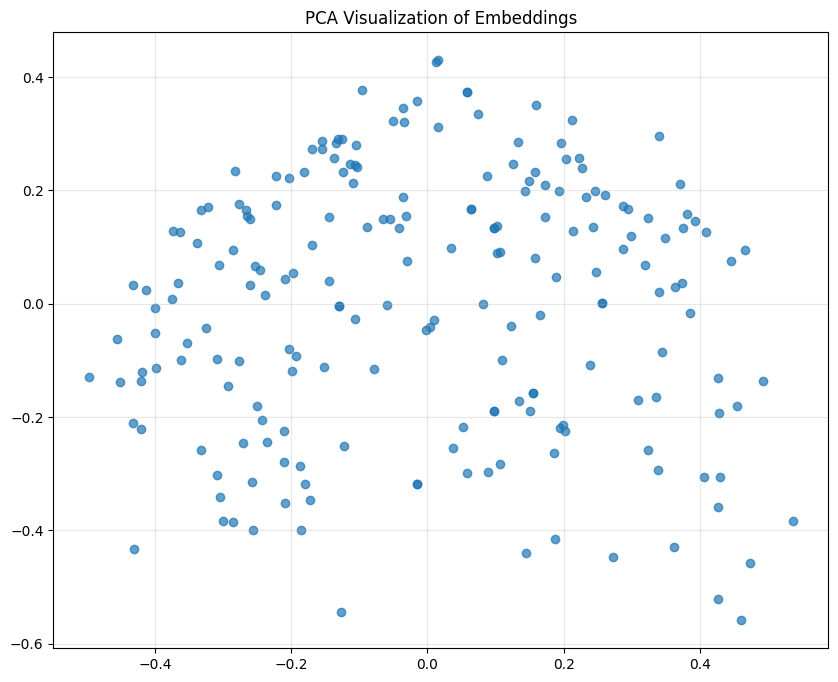

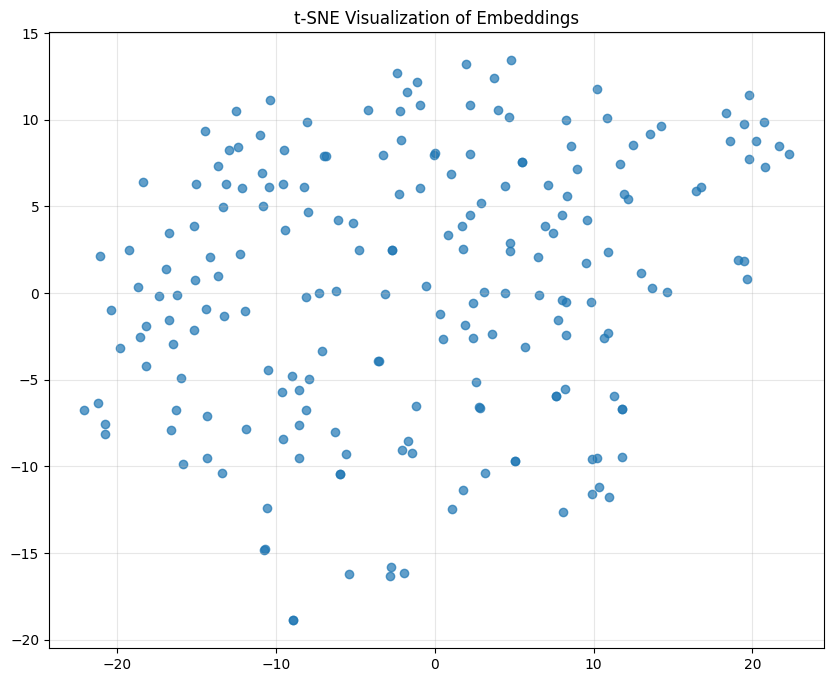

In [28]:
# Analyze the embeddings
if len(chunks_with_embeddings) > 0:
    pca_result, tsne_result = analyze_embeddings(embeddings_array, chunks_metadata, output_dir)
    
    # Display the PCA plot
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('PCA Visualization of Embeddings')
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(output_dir, "pca_plot.png"))
    
    # Display the t-SNE plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title('t-SNE Visualization of Embeddings')
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(output_dir, "tsne_plot.png"))
else:
    logger.warning("Skipping embedding analysis as no valid embeddings were generated")

## Summary

In this notebook, we have:

1. Loaded markdown chunks from the `data/chunks` directory
2. Generated embeddings for those chunks using the Sentence Transformer model
3. Saved the embeddings in various formats for later use
4. Analyzed the embeddings using dimensionality reduction techniques (PCA and t-SNE)
5. Created visualizations of the embeddings

The generated embeddings can now be used for retrieval tasks or to build a vector database for a RAG system.